In [66]:
from pathlib import Path
# Directory
cwd = Path.cwd()
data_dir = cwd.parent.parent/"data"

In [67]:
import sys
import os

# Add the project root directory to the Python path
# The notebook is in MLP/interpretatable_test, so we go up two directories from the notebook's location
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Now you can import from the OSCC_postprocessing module
from OSCC_postprocessing.cine.functions_videos import get_subfolder_names

# You can now use the imported function
print("Successfully imported get_subfolder_names")


Successfully imported get_subfolder_names


In [68]:
subfolders =get_subfolder_names(data_dir)

In [69]:
import pandas as pd

df = pd.DataFrame()
for subfolder in subfolders:

    temp = pd.read_csv(os.path.join(data_dir, subfolder, str(subfolder + "_test_data.csv")))

    df = pd.concat([df, temp.dropna()], ignore_index=True)

df = df.drop(columns=["Unnamed: 0"])
print(f"Test dataset has {df.shape[1]} features (parameters) and {df.shape[0]} datapoints" )


Test dataset has 12 features (parameters) and 11023 datapoints


In [70]:
# I haven't calibrated the images, all px2mm_scale =1 
# All injection pressure is 2000
df.drop(columns=['px2mm_scale', "injection_pressure"], inplace=True)
print("Columns in the dataset:", df.columns)
df.head()
# df.columns

Columns in the dataset: Index(['penetration_average', 'penetration_median', 'penetration_std',
       'frame_number', 'time_us', 'chamber_pressure', 'injection_duration',
       'tilt_angle', 'plumes', 'diamter'],
      dtype='object')


,penetration_average,penetration_median,penetration_std,frame_number,time_us,chamber_pressure,injection_duration,tilt_angle,plumes,diamter
0,0.0,0.0,0.0,0,0.0,5,560.0,0.349066,10,0.384
1,0.0,0.0,0.0,1,40.0,5,560.0,0.349066,10,0.384
2,0.0,0.0,0.0,2,80.0,5,560.0,0.349066,10,0.384
3,0.0,0.0,0.0,3,120.0,5,560.0,0.349066,10,0.384
4,0.0,0.0,0.0,4,160.0,5,560.0,0.349066,10,0.384


In [ ]:
# Loading the Neural Network
import numpy as np
import onnxruntime as ort
from pathlib import Path

print("CWD:", Path.cwd())

base = Path(r"c:/Users/Jiang/Documents/Mie_Py/Mie_Postprocessing_Py")
onnx_path = base / "MLP" / "runs_mlp" / "penetration_hetero_20251212_110530" / "best_model.onnx"
print("ONNX path:", onnx_path)
onnx_path = onnx_path.resolve(strict=True)  # raises if missing

sess = ort.InferenceSession(onnx_path.as_posix())
print("Inputs:", sess.get_inputs())
print("Outputs:", sess.get_outputs())

# dummy = np.random.randn(2, 6).astype(np.float32)
# pred = sess.run(None, {"features": dummy})
# print(pred)


CWD: c:\Users\Jiang\Documents\Mie_Py\Mie_Postprocessing_Py\MLP\interpretatable_test
ONNX path: c:\Users\Jiang\Documents\Mie_Py\Mie_Postprocessing_Py\MLP\runs_mlp\penetration_hetero_20251212_110530\best_model.onnx
Inputs: [<onnxruntime.capi.onnxruntime_pybind11_state.NodeArg object at 0x000002223F28A6F0>]
Outputs: [<onnxruntime.capi.onnxruntime_pybind11_state.NodeArg object at 0x000002223B0D4BB0>]


In [88]:
import json, numpy as np, onnxruntime as ort
from pathlib import Path
import pandas as pd

run_dir = Path(r"c:/Users/Jiang/Documents/Mie_Py/Mie_Postprocessing_Py/MLP/runs_mlp/penetration_hetero_20251212_110530")
feature_cols = ["time_ms","tilt_angle_radian","plumes","diameter_mm","chamber_pressure","injection_duration"]

# load data row(s) to test
# df = pd.read_csv(run_dir.parent / "some_input.csv")  # replace with your source
df["time_ms"] = 1e-3 * df["time_us"]
df["diameter_mm"] = df["diamter"]
df['tilt_angle_radian'] = df["tilt_angle"]
X = df[feature_cols].to_numpy(dtype=np.float32)

# standardize using saved scalers
scalers = json.loads((run_dir / "scalers.json").read_text())
mu = np.array(scalers["x"]["mu"], dtype=np.float32)
sigma = np.array(scalers["x"]["sigma"], dtype=np.float32)
X_std = (X - mu) / sigma

sess = ort.InferenceSession((run_dir / "best_model.onnx").as_posix())
pred = sess.run(None, {"working conditions": X_std})[0]
print(pred)


[[-1.8613272 -5.8760204]
 [-1.860214  -5.863197 ]
 [-1.8588369 -5.847331 ]
 ...
 [ 1.542872  -2.09858  ]
 [ 1.6725008 -2.0555954]
 [ 1.7661941 -2.041768 ]]


In [ ]:
# Input feature 
'''
time_ms
tilt_angle_radian
plumes
diameter_mm
chamber_pressure
injection_duration
'''

# Group data by working conditions
groups = df.groupby(["chamber_pressure", "injection_duration", "tilt_angle_radian", "plumes", "diameter_mm"])
len(groups)

254

In [105]:
import json, numpy as np, onnxruntime as ort, pandas as pd
from pathlib import Path

run_dir = Path(r"c:/Users/Jiang/Documents/Mie_Py/Mie_Postprocessing_Py/MLP/runs_mlp/penetration_hetero_20251212_110530")
feature_cols = ["time_ms","tilt_angle_radian","plumes","diameter_mm","chamber_pressure","injection_duration"]
group_cols   = ["tilt_angle_radian","plumes","diameter_mm","chamber_pressure","injection_duration"]

# load your raw data
# df = pd.read_csv(run_dir.parent / "some_input.csv")  # replace
df["time_ms"] = 1e-3 * df["time_us"]
df["diameter_mm"] = df["diamter"]
df["tilt_angle_radian"] = df["tilt_angle"]

# load scalers and session
scalers = json.loads((run_dir / "scalers.json").read_text())
mu = np.array(scalers["x"]["mu"], dtype=np.float32)
sigma = np.array(scalers["x"]["sigma"], dtype=np.float32)
sess = ort.InferenceSession((run_dir / "best_model.onnx").as_posix())
input_name = sess.get_inputs()[0].name  # e.g., "features" or "working conditions"

time_grid = np.linspace(0.0, 3.0, 301, dtype=np.float32)  # 0..3 ms, 0.01 step
group_results = []

for vals, _ in df.groupby(group_cols):
    # vals is a tuple in same order as group_cols
    static_feats = np.array(vals, dtype=np.float32)  # shape (5,)
    X = np.column_stack([time_grid, np.repeat(static_feats[None, :], len(time_grid), axis=0)])  # (T,6)
    X_std = (X - mu) / sigma
    preds = sess.run(None, {input_name: X_std})[0]  # shape (T,2)
    mu_pred = preds[:, 0]
    sigma_pred = preds[:, 1]  # if this is log-sigma, use np.exp(0.5 * preds[:,1]) for std
    group_results.append({
        "conds": dict(zip(group_cols, vals)),
        "time_ms": time_grid,
        "mu": mu_pred,
        "sigma": sigma_pred,
    })

# Example: access first group
g0 = group_results[0]
print("conds:", g0["conds"])
print("mu curve:", g0["mu"])
print("sigma curve:", g0["sigma"])


conds: {'tilt_angle_radian': np.float64(0.1396263401595463), 'plumes': np.int64(12), 'diameter_mm': np.float64(0.365), 'chamber_pressure': np.int64(5), 'injection_duration': np.float64(580.0)}
mu curve: [-1.854737   -1.8544598  -1.8541784  -1.8538985  -1.8536122  -1.8533175
 -1.8530135  -1.8526978  -1.8523738  -1.8520415  -1.8516984  -1.8513439
 -1.8509796  -1.8505957  -1.8501971  -1.8497872  -1.8493655  -1.8489313
 -1.8484845  -1.8480246  -1.8475201  -1.846962   -1.8463829  -1.8457842
 -1.8451657  -1.8445041  -1.8437974  -1.8430667  -1.8423104  -1.8415263
 -1.8407133  -1.8398631  -1.8389611  -1.8380091  -1.8370144  -1.8359783
 -1.8349049  -1.833787   -1.832619   -1.8313715  -1.8300107  -1.8285692
 -1.827055   -1.825463   -1.8237696  -1.8219514  -1.8200328  -1.8180065
 -1.8158317  -1.8135021  -1.8109491  -1.8081183  -1.8046758  -1.8005424
 -1.7951698  -1.7895076  -1.7833405  -1.7766232  -1.767765   -1.7574856
 -1.7445328  -1.7301672  -1.7139988  -1.6952586  -1.6763484  -1.6552508
 -1.6

In [120]:
import random
import numpy as np
import matplotlib.pyplot as plt

# Columns that define a working condition (same as before)
group_cols = ["tilt_angle_radian","plumes","diameter_mm","chamber_pressure","injection_duration"]

# Group the data and pick one at random
grouped = df.groupby(group_cols)
key = random.choice(list(grouped.groups.keys()))
gdf = grouped.get_group(key).sort_values("time_ms")
'''
time_meas = gdf["time_ms"].to_numpy()
avg = gdf["penetration_average"].to_numpy()
med = gdf["penetration_median"].to_numpy()
std = gdf["penetration_std"].to_numpy()

# Find the matching model sweep for this group
match = next(gr for gr in group_results if all(np.isclose(gr["conds"][c], v) for c, v in zip(group_cols, key)))
time_pred = match["time_ms"]
mu_pred = match["mu"]
# If your model’s second output is log-variance, uncomment the next line; otherwise use match["sigma"] directly:
# std_pred = np.exp(0.5 * match["sigma"])
std_pred = match["sigma"]

plt.figure(figsize=(8, 5))
plt.fill_between(time_meas, avg - std, avg + std, color="C0", alpha=0.2, label="Measured ± std")
plt.plot(time_meas, avg, color="C0", lw=2, label="Measured mean")
plt.plot(time_meas, med, color="C1", lw=2, ls="--", label="Measured median")
plt.plot(time_pred, mu_pred, color="C2", lw=2, label="Model mean")
plt.fill_between(time_pred, mu_pred - std_pred, mu_pred + std_pred, color="C2", alpha=0.15, label="Model ± std")
plt.xlabel("time_ms"); plt.ylabel("penetration"); plt.title(f"Group: {dict(zip(group_cols, key))}")
plt.legend(); plt.tight_layout()
plt.show()
'''


'\ntime_meas = gdf["time_ms"].to_numpy()\navg = gdf["penetration_average"].to_numpy()\nmed = gdf["penetration_median"].to_numpy()\nstd = gdf["penetration_std"].to_numpy()\n\n# Find the matching model sweep for this group\nmatch = next(gr for gr in group_results if all(np.isclose(gr["conds"][c], v) for c, v in zip(group_cols, key)))\ntime_pred = match["time_ms"]\nmu_pred = match["mu"]\n# If your model’s second output is log-variance, uncomment the next line; otherwise use match["sigma"] directly:\n# std_pred = np.exp(0.5 * match["sigma"])\nstd_pred = match["sigma"]\n\nplt.figure(figsize=(8, 5))\nplt.fill_between(time_meas, avg - std, avg + std, color="C0", alpha=0.2, label="Measured ± std")\nplt.plot(time_meas, avg, color="C0", lw=2, label="Measured mean")\nplt.plot(time_meas, med, color="C1", lw=2, ls="--", label="Measured median")\nplt.plot(time_pred, mu_pred, color="C2", lw=2, label="Model mean")\nplt.fill_between(time_pred, mu_pred - std_pred, mu_pred + std_pred, color="C2", alpha=0

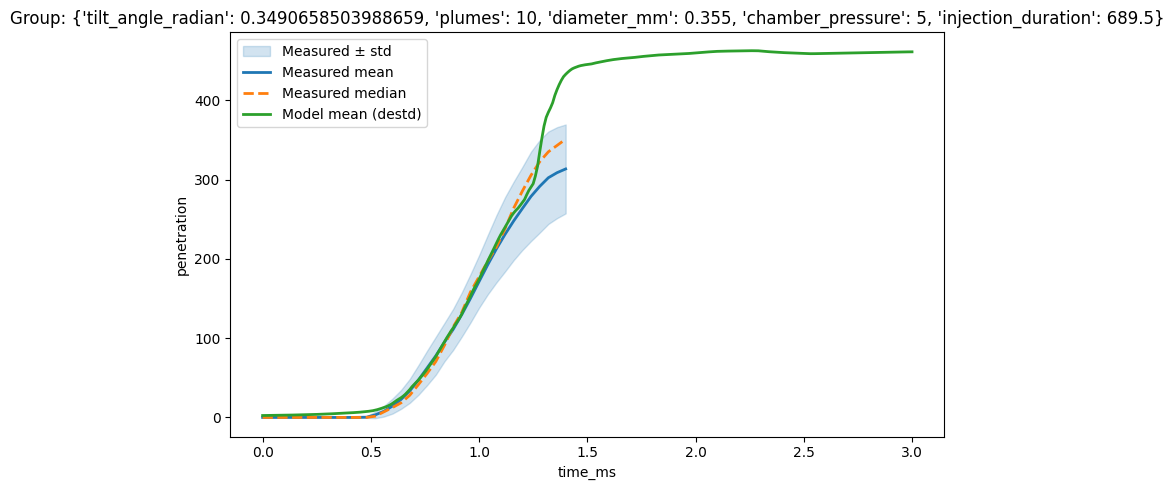

: 

In [ ]:
# load target scaler (once, after you loaded scalers)
y_mu = np.array(scalers["y"]["mu"], dtype=np.float32).ravel()      # shape (2,)
y_sigma = np.array(scalers["y"]["sigma"], dtype=np.float32).ravel()

# ... inside the plotting block, after you get mu_pred/std_pred ...
# if std_pred is already std in standardized space:
mu_raw = mu_pred * y_sigma[0] + y_mu[0]
std_raw = std_pred * y_sigma[0]       # assumes output 0 is mean, output 1 is std in standardized units

# if output[1] is log-variance instead, use:
# std_raw = np.exp(0.5 * std_pred) * y_sigma[0]

plt.figure(figsize=(8, 5))
plt.fill_between(time_meas, avg - std, avg + std, color="C0", alpha=0.2, label="Measured ± std")
plt.plot(time_meas, avg, color="C0", lw=2, label="Measured mean")
plt.plot(time_meas, med, color="C1", lw=2, ls="--", label="Measured median")
plt.plot(time_pred, mu_raw, color="C2", lw=2, label="Model mean (destd)")
# plt.fill_between(time_pred, mu_raw - std_raw, mu_raw + std_raw, color="C2", alpha=0.15, label="Model ± std (destd)")
plt.xlabel("time_ms"); plt.ylabel("penetration"); plt.title(f"Group: {dict(zip(group_cols, key))}")
plt.legend(); plt.tight_layout(); plt.show()


In [104]:
df

,penetration_average,penetration_median,penetration_std,frame_number,time_us,chamber_pressure,injection_duration,tilt_angle,plumes,diamter,time_ms,diameter_mm,tilt_angle_radian
0,0.00,0.0,0.000000,0,0.0,5,560.0,0.349066,10,0.384,0.0,0.384,0.349066
1,0.00,0.0,0.000000,1,40.0,5,560.0,0.349066,10,0.384,40000.0,0.384,0.349066
2,0.00,0.0,0.000000,2,80.0,5,560.0,0.349066,10,0.384,80000.0,0.384,0.349066
3,0.00,0.0,0.000000,3,120.0,5,560.0,0.349066,10,0.384,120000.0,0.384,0.349066
4,0.00,0.0,0.000000,4,160.0,5,560.0,0.349066,10,0.384,160000.0,0.384,0.349066
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11018,250.18,308.0,126.630437,45,1800.0,15,764.0,0.436332,10,0.365,1800000.0,0.365,0.436332
11019,253.46,310.5,128.299370,46,1840.0,15,764.0,0.436332,10,0.365,1840000.0,0.365,0.436332
11020,255.90,311.5,129.528568,47,1880.0,15,764.0,0.436332,10,0.365,1880000.0,0.365,0.436332
11021,256.46,312.0,129.818675,48,1920.0,15,764.0,0.436332,10,0.365,1920000.0,0.365,0.436332
